# Real time: FRB 220330aaan

In [1]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn_vec, sgram_fn_vec, sgram_fn, gauss, gauss_norm, model_free_4,model_free, power_law
from burstfit.utils.plotter import plot_fit_results, plot_2d_fit 
from burstfit.io import BurstIO
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
# use Liam's function to read in filterbank files 
import sys
sys.path.insert(1, '/home/ubuntu/gechen/software')
import filplot_funcs_gc as ff

%matplotlib inline 


# input variables 
candidate = '220330aaan'
datestring = '2022_3_29_23_4_54'
beam = 164
corr = 'corr09'
snr_heimdall = 12.9
dm_heimdall = 467.8
width_heimdall = 32 
mask_chans=[] 

fil_file ='/data/dsa110/T1/'+corr + '/' + datestring + '/fil_'+candidate+'/'+candidate+'_'+str(beam)+'.fil'
save_name = candidate + '_beam_'+str(beam)
save_dir = '/home/ubuntu/gechen/burstfit_tests_outputs/' 



logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)

# create burst object 
bd = BurstData(
    fp=fil_file,
    dm=dm_heimdall ,
    tcand=0.5, # pulse starting time in s.
    width=width_heimdall,  
    snr=snr_heimdall
)

bd.prepare_data()

# number of channels after binning 
# requires each channel bin to have SNR_min 
# snr_heimdall was calculated with all 256 channels binned into one 
SNR_min = 5 # check?  
n_per_bin = int(256. / (1.0*snr_heimdall / SNR_min)**2) 
if n_per_bin <= 1:
    n_per_bin = 1
elif not math.log(n_per_bin, 2).is_integer():
    n_per_bin = 2 ** (int(np.log2(n_per_bin))+1)
    
nfreq_snr = int(256 / n_per_bin) 
print(nfreq_snr)


/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/burstfit-0.1.1-py3.6.egg/burstfit/utils/plotter.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/ubuntu/anac

datacite/tind env not found. Cannot use datacite API


2022-06-26 02:03:54,074 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2022-06-26 02:03:54,180 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2022-06-26 02:03:54,185 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2022-06-26 02:03:54,223 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (36.063605401529635, 21.164850863543236)


4


## de-disperse data (or read from file) and chop near the burst time

In [2]:
# # save the de-dispersed data to file (de-dispersion takes long time)
# nfreq = min(4, nfreq_snr)

# data = ff.proc_cand_fil(fil_file, bd.dm, bd.width, nfreq_plot=nfreq, ndm=64)[0]
# np.save('%s_%d.txt'%(candidate, nfreq), data, allow_pickle=False)

In [8]:
# chop near the burst region and plot (adjust as needed, but sometimes fit results change)
i_low = int(0.500/bd.tsamp - 5*bd.width)
i_high = int(0.500/bd.tsamp + 5*bd.width)
i_low, i_high

0.500/bd.tsamp 

1907.3486328124998

Text(0.5,0,'time sample')

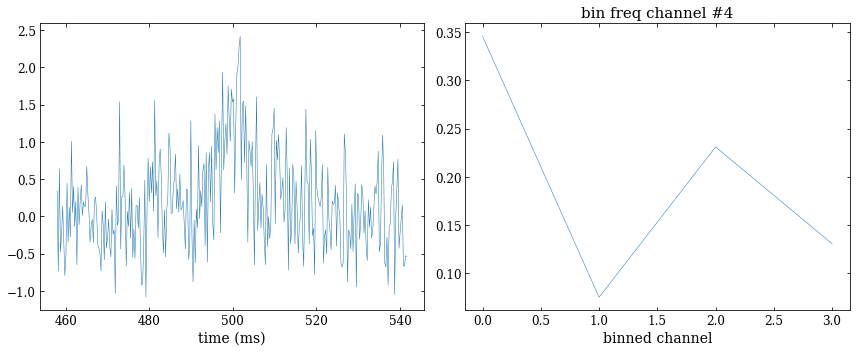

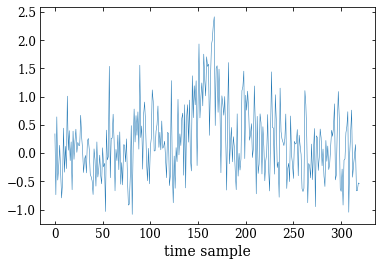

In [5]:
# read in de-dispersed data file
# nfreq = min(4, nfreq_snr)

nfreq = 4 # two channels is too weak for fitting dm and tau? 
data = np.load('%s_%d.txt.npy'%(candidate, nfreq))

# chop near the burst region and plot 
data_burst = data[:, i_low: i_high] # change to x * width 
t_burst_ms = [i * bd.tsamp * 1e3 for i in range(i_low, i_high)]

fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5)) 
#fig1.set_size_inches(12., 5.)
ax1[0].plot(t_burst_ms, data_burst.mean(0))
ax1[0].set_xlabel('time (ms)')
ax1[1].plot(data_burst.mean(1))
ax1[1].set_xlabel('binned channel')
ax1[1].set_title('bin freq channel #%d'%nfreq)
plt.tight_layout()

plt.figure()
plt.plot(data_burst.mean(0))
plt.xlabel('time sample')

## Fit with models

### bf_S1T2_cx: model-free spectrum + gaussian with scattering profile + x components

self.function_input_names:  ['S', 'mu', 'sigma', 'tau']
snames: ['c0', 'c1', 'c2', 'c3']
self.function_input_names:  ['c0', 'c1', 'c2', 'c3']


2022-05-12 23:26:27,418 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-12 23:26:27,422 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-12 23:26:27,434 - tests -root - INFO - P values: T-test (0.94271), Kruskal (0.90986), KS (0.77281), F-test (0.09014)
2022-05-12 23:26:27,436 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-12 23:26:27,439 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00000)
2022-05-12 23:26:27,441 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-12 23:26:27,444 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00003)
2022-05-12 23:26:27,450 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-05-12 23:26:27,452 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-05-12 23:26:27,530 - initial_profilefi

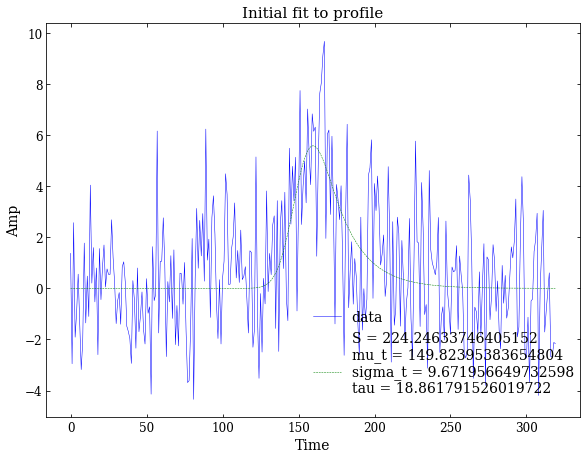

2022-05-12 23:26:27,823 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-12 23:26:27,825 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_4 at 0x7fd3a3eeaf28>
[0.40324998 0.25438893 0.44648644 0.19499925]


2022-05-12 23:26:27,834 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-12 23:26:27,837 - initial_spectrafit -burstfit.fit - INFO - c0: 0.40324997901916504 +- 0.0
2022-05-12 23:26:27,840 - initial_spectrafit -burstfit.fit - INFO - c1: 0.2543889284133911 +- 0.0
2022-05-12 23:26:27,842 - initial_spectrafit -burstfit.fit - INFO - c2: 0.4464864432811737 +- 0.0
2022-05-12 23:26:27,844 - initial_spectrafit -burstfit.fit - INFO - c3: 0.19499924778938293 +- 0.0


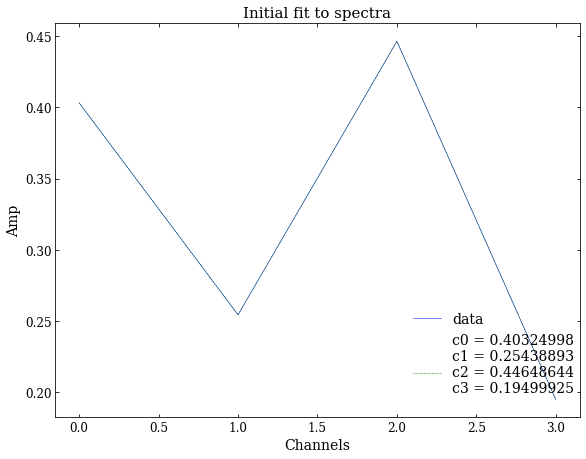

2022-05-12 23:26:28,043 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-12 23:26:28,045 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.40324998, 0.25438893, 0.44648644, 0.19499925, 224.24633746405152, 149.82395383654804, 9.671956649732598, 18.861791526019722, 467.8]
2022-05-12 23:26:28,125 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-12 23:26:28,126 - sgram_fit -burstfit.fit - INFO - c0: 0.26754172023930445 +- 0.03287827931080724
2022-05-12 23:26:28,127 - sgram_fit -burstfit.fit - INFO - c1: 0.17405406406112345 +- 0.034612713401727446
2022-05-12 23:26:28,129 - sgram_fit -burstfit.fit - INFO - c2: 0.37548730414351017 +- 0.040052802800262806
2022-05-12 23:26:28,131 - sgram_fit -burstfit.fit - INFO - c3: 0.166949064545966 +- 0.03913115872989173
2022-05-12 23:26:28,134 - sgram_fit -burstfit.fit - INFO - S: 249.42389087364884 +- 9.582145040638576
2022-05-12 23:26:28,135 - sgram_fit -burstfit.fit - INFO - m

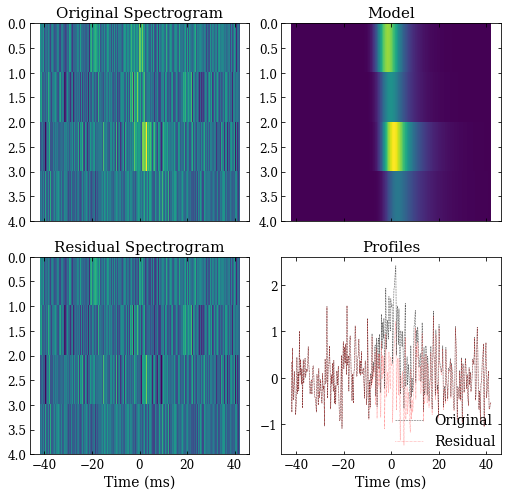

2022-05-12 23:26:28,676 - model -burstfit.fit - INFO - Making model.
2022-05-12 23:26:28,677 - model -burstfit.fit - INFO - Found 1 components.
2022-05-12 23:26:28,680 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-12 23:26:28,682 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-12 23:26:28,683 - model -burstfit.fit - INFO - Making model.
2022-05-12 23:26:28,685 - model -burstfit.fit - INFO - Found 1 components.
2022-05-12 23:26:28,689 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.213231479373376
2022-05-12 23:26:28,691 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-12 23:26:28,692 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-12 23:26:28,697 - tests -root - INFO - P values: T-test (0.94271), Kruskal (0.90986), KS (0.77281), F-test (0.09014)
2022-05-12 23:26:28,698 - run_

bf_S1T2_c1.calc_redchisq()= 1.213231479373376


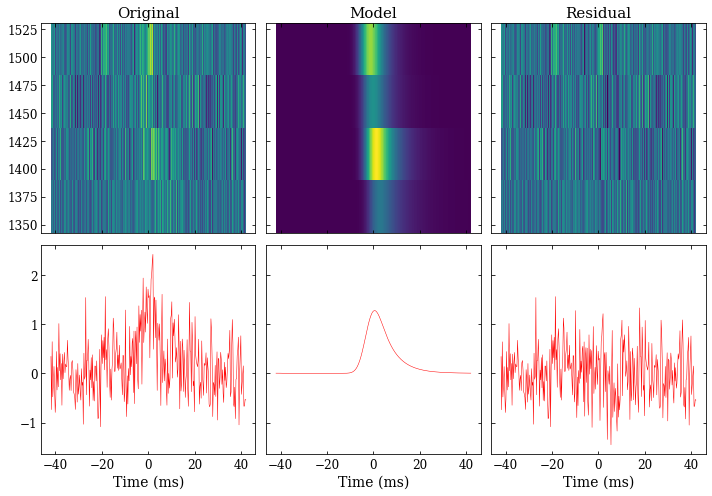

In [15]:
# bf_S1T2_c1: single component 
#data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)] # change to x * width 
#fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel

ncomp = 1 

pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)
profile_bounds=[(0, 480, 0, 0),(np.inf, 510, 5*bd.width, np.inf)]


nfreq = 4
# For spectrum, try model-free  
nfreq_model = nfreq # try less 
snames = [0] * (nfreq_model)

for i in range(nfreq_model ):
    snames[i] = 'c'+str(i)

print('snames:', snames)
spectraModel = Model(model_free_4, param_names=snames)
#spectraModel = Model(model_free, param_names=snames)





sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

#sgram_bounds=((0, 0.45, 0),(np.inf, 0.55, np.inf)) # did not work when only set up bounds but do not chop data 

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
# rename bf_S1T2_c1 for later model selection 
bf_S1T2_c1 = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    #comp_num = 1, 
)


# Some setting up before we do the fitting 
bf_S1T2_c1.validate()
bf_S1T2_c1.precalc()


# fit tests
#bf_S1T2_c1.initial_profilefit(plot = True) #bounds = profile_bounds, 
#bf_S1T2_c1.make_spectra
#bf_S1T2_c1.initial_spectrafit(plot = True)

#bf_S1T2_c1.fitcycle(plot=True) # fit for one component.
bf_S1T2_c1.fitall(plot=True, max_ncomp = ncomp) # fit all componnts 
print('bf_S1T2_c1.calc_redchisq()=', bf_S1T2_c1.calc_redchisq())

# plot fit for all components 
plot_fit_results(bf_S1T2_c1.sgram, bf_S1T2_c1.sgram_model.evaluate, bf_S1T2_c1.sgram_params['all'][1]['popt'], 
                 bf_S1T2_c1.tsamp, bf_S1T2_c1.fch1, bf_S1T2_c1.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
dm_fit, dm_fit_err = bf_S1T2_c1.sgram_params['all'][1]['popt'][-1], bf_S1T2_c1.sgram_params['all'][1]['perr'][-1]



### Find the optimal bin size and bin number

In [29]:
# estimate
def bin_best(bf, mcmc=False, tsamp_fine = 32.768e-6):
    
    sig_idx = np.where(np.array(bf.param_names) == "sigma_t")[0][0]
    tau_idx = np.where(np.array(bf.param_names) == "tau")[0][0]

    if mcmc: 
        sigma = bf.mcmc_params[bf.comp_num]["popt"][sig_idx]
        tau = bf.mcmc_params[bf.comp_num]["popt"][tau_idx]
    else:
        sigma = bf.sgram_params[bf.comp_num]["popt"][sig_idx]
        tau = bf.sgram_params[bf.comp_num]["popt"][tau_idx]
    
    width_samp = 2.335 * sigma + tau 
    width_samp_fine = width_samp * bd.tsamp / tsamp_fine 
    width_samp_fine_pow2 = 2 ** int(np.log2(width_samp_fine))
        
    return int(width_samp), width_samp_fine_pow2 
 

    
def bin_number(bf, width_samp_fine, mcmc=False, tsamp_fine = 32.768e-6):
    mu_idx = np.where(np.array(bf.param_names) == "mu_t")[0][0]
    
    if mcmc:
        mu = bf.mcmc_params[bf.comp_num]["popt"][mu_idx] # count from the chopped time window
    else: 
        mu = bf.sgram_params[bf.comp_num]["popt"][mu_idx]
    
    mu_ms = bd.tsamp * (i_low + mu) # count from gulp t0  
    mu_samp_fine = mu_ms / tsamp_fine 
    
    return int(mu_samp_fine / width_samp_fine) # count from bin 0 


# loop over adjecent choices to compare SNR

def Dedisperse_data_profile(bf, fil_file, width, nfreq = 4, ndm = 64):
    dm_fit_idx = np.where(np.array(bf.param_names) == "DM")[0][0]
    dm_fit = bf.sgram_params[bf.comp_num]["popt"][dm_fit_idx] 
    
    print("dedispersing using DM = %.2f)"%dm_fit)
    data = ff.proc_cand_fil(fil_file, dm_fit, width, nfreq_plot=nfreq, ndm=ndm)[0]
        
    return data, dm_fit


def Bin_profile(data, bin_size):
    data_t = data.mean(0)
    data_t_binned = np.array([])
    
    if bin_size == 1:
        data_t_binned = data_t
    elif bin_size > 1: 
        for i in range(0, len(data_t), bin_size):
            bin_value = np.sum(data_t[i : i + bin_size])
            data_t_binned = np.append(data_t_binned, bin_value)
    else: 
        print("bin_size is negative.")
    
    return data_t_binned 
        

def Snr(data_t_bin):
    signal = np.max(data_t_bin)
    peak_idx = np.argmax(data_t_bin)
    residual = np.concatenate([data_t_bin[0 : peak_idx - 1], data_t_bin[peak_idx + 2 : -1]])
    noise = np.std(residual)

    return signal / noise 


def Compare_bins(data, width_samp_fine_pow2, tsamp_fine = 32.768e-6):
    snr_arr = np.array([])
    width_fine_arr = np.array([])
    width_power = int(np.log2(width_samp_fine_pow2))

    for width_pow2 in range(max(int(np.log2(bd.tsamp / tsamp_fine)), width_power - 1), width_power + 4):
        width_fine = 2 ** width_pow2
        print(width_fine)
        width_fine_arr = np.append(width_fine_arr, width_fine)
        width_filterbank = int(width_fine * tsamp_fine / bd.tsamp)

        data_t_binned = Bin_profile(data, width_filterbank)
        snr = Snr(data_t_binned)
        snr_arr = np.append(snr_arr, snr)

        plt.figure()
        plt.plot(data_t_binned)
        plt.title("bin size (at 32.768e-6s) = %d, snr = %.2f"%(width_fine, snr))
        
    best_bin_snr_idx = np.argmax(snr_arr)
    best_bin_snr = int(width_fine_arr[best_bin_snr_idx])
    
    print("fine resolution bin size (at 32.768e-6s) that gives the max snr: %d"%best_bin_snr)
    
    return best_bin_snr 




width_samp, width_samp_fine_pow2, bin_num =  41 256 59
128
256
512
1024
2048
fine resolution bin size that gives the max snr: 256


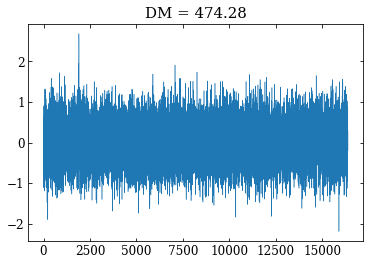

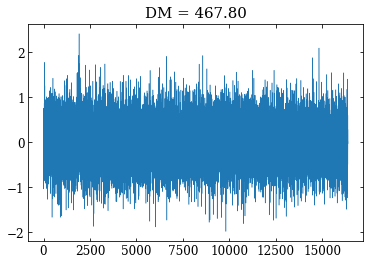

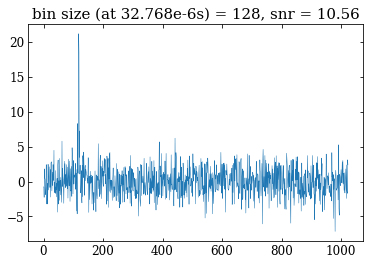

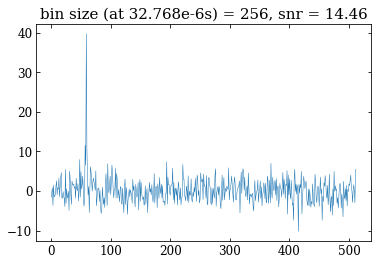

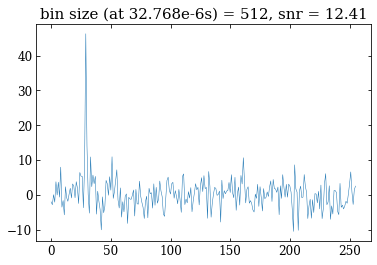

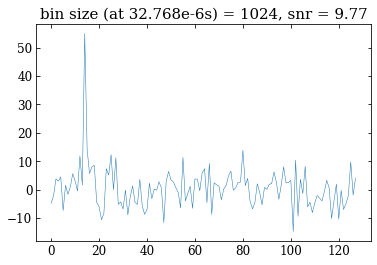

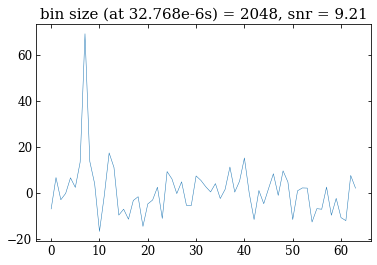

In [30]:
width_samp, width_samp_fine_pow2 = bin_best(bf_S1T2_c1)
bin_num = bin_number(bf_S1T2_c1, width_samp_fine_pow2)
print("width_samp, width_samp_fine_pow2, bin_num = ", width_samp, width_samp_fine_pow2, bin_num)

data_new_dm, dm_fit = Dedisperse_data_profile(bf_S1T2_c1, fil_file, width_samp)

plt.plot(data_new_dm.mean(0))
plt.title("DM = %.2f"%dm_fit)
plt.figure()
plt.plot(data.mean(0))
plt.title("DM = %.2f"%bd.dm)


best_bin_snr = Compare_bins(data_new_dm, width_samp_fine_pow2)

### MCMC may not converge.  Will not us since previous method enough for real time.

2022-05-13 20:13:36,036 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2022-05-13 20:13:36,042 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [2.67541720e-01 1.74054064e-01 3.75487304e-01 1.66949065e-01
 2.49423891e+02 1.44931541e+02 1.00974455e+01 1.76265123e+01
 4.74282257e+02]
2022-05-13 20:13:36,048 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2022-05-13 20:13:36,051 - set_priors -burstfit.mcmc - INFO - Found tau in param_names. Setting its min value of prior to 0.
2022-05-13 20:13:36,054 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2022-05-13 20:13:36,056 - set_priors -burstfit.mcmc - INFO - Found sigma_t and tau in param_names. Setting its max value of prior to 2*(max_tau_prior(31.727722071219382) + max_sigma_t_prior(18.175401956054603))
2022-05-13 20:13:36,057 - set_priors -burstfit.mcmc - INFO - Found S and sigma_t in param_names. Setting its max value of prio

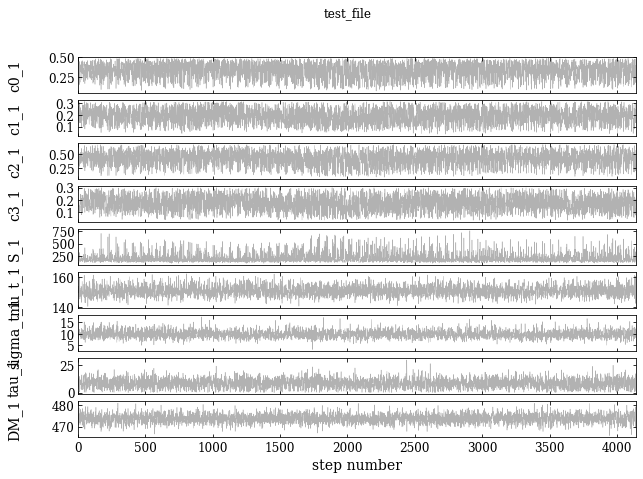

<Figure size 432x288 with 0 Axes>

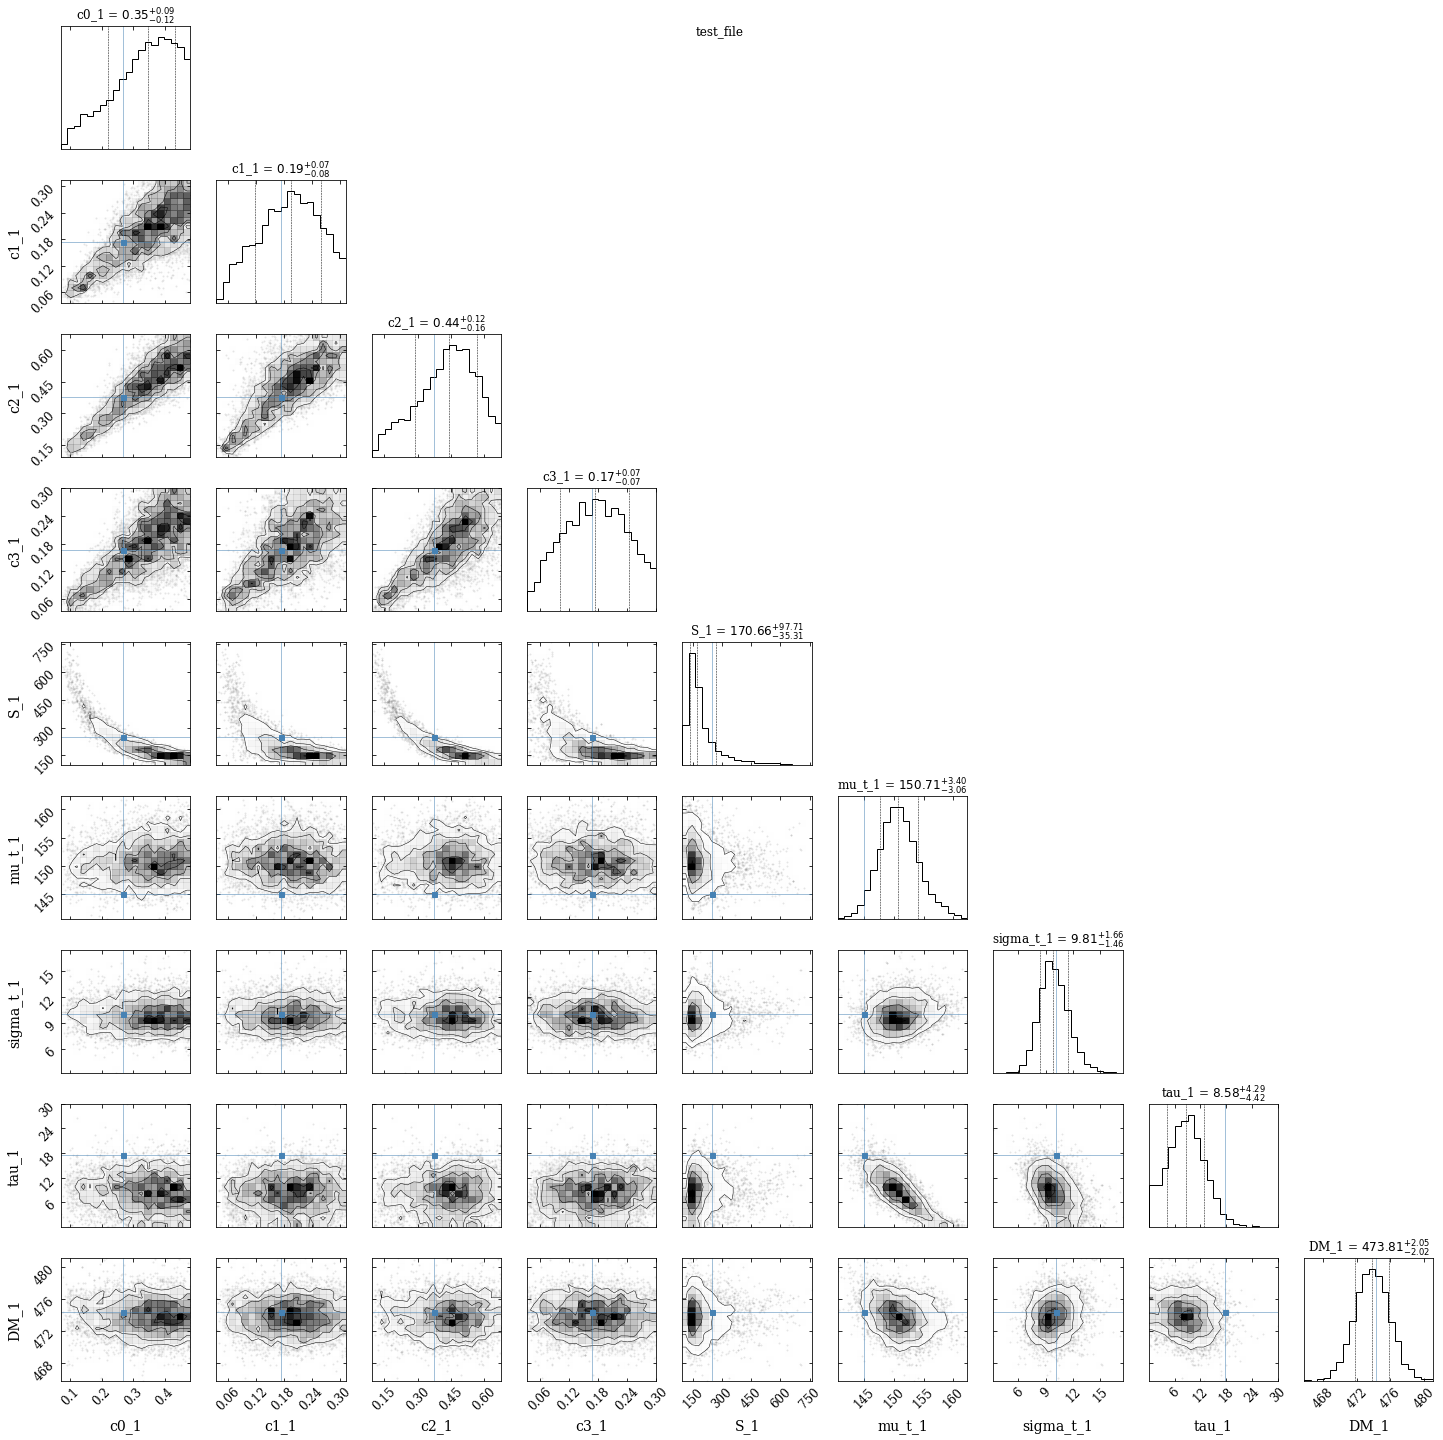

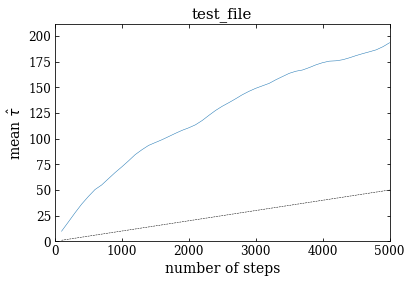

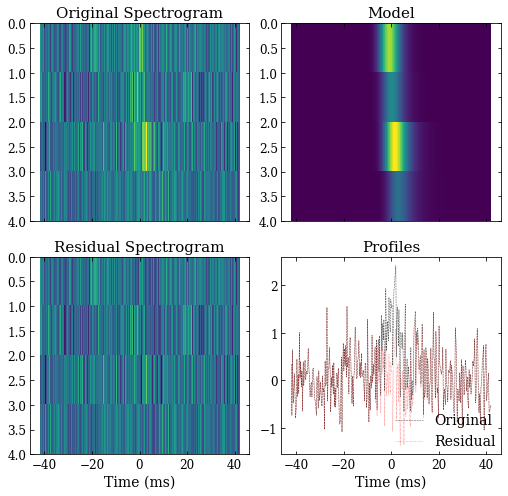

In [28]:
mcmc_kwargs = {}
mcmc_kwargs = {'nwalkers':60, 'nsteps':int(5000),
           'skip':500, 'ncores':4, 
           'start_pos_dev':0.01,
           'prior_range':0.8, 
           'save_results':True,
           'outname':'test_file'}

bf_S1T2_c1.run_mcmc(plot=True, **mcmc_kwargs)


In [25]:
# use mcmc 
width_samp_fine_pow2 = bin_best(bf_S1T2_c1, mcmc=True)
bin_num = bin_number(bf_S1T2_c1, width_samp_fine_pow2, mcmc=True)

print(width_samp_fine_pow2, bin_num)

1024 14


### save results (will integrate with real time pipeline later)

In [ ]:
# save fitting results 
bd.prepare_data()
bio = BurstIO(bf, bd)
d = bio.save_results(outname=save_name+"_fit_results.json", outdir=save_dir)  
print(d['param_names'])

In [19]:
# # saving key burst paramters 
# mu_f_mcmc, sigma_f_mcmc, s_mcmc, mu_t_mcmc, sigma_t_mcmc, tau_mcmc, dm_mcmc = bf.mcmc_params[1]['popt']
# mu_f_mcmc_err, sigma_f_mcmc_err, s_mcmc_err, mu_t_mcmc_err, sigma_t_mcmc_err, tau_mcmc_err, dm_mcmc_err = bf.mcmc_params[1]['perr']

# t0 = 0.45 + mu_t_mcmc * bd.tsamp
# t0_err = [i * bd.tsamp for i in mu_t_mcmc_err] 

# width_ms = sigma_t_mcmc * bd.tsamp * 1e3 # in ms
# width_ms_err = [i * bd.tsamp for i in sigma_t_mcmc_err] 

# # with open(save_dir+save_name+"_fit_key_results.txt") as f:
# #     print('mu_f_mcmc, sigma_f_mcmc, s_mcmc, mu_t_mcmc, sigma_t_mcmc, tau_mcmc, dm_mcmc')
# #     print(bf.mcmc_params[1]['popt'])
# #     print('lower, upper bounds')
# #     print(bf.mcmc_params[1]['perr'])

# #outname=save_name+"_fit_results.json", outdir=save_dir